In [1]:
script_path = "/n/home02/amphillips/p26/scripts" # for cannon

#-------------- for working on my machine:
# script_path = '/Users/anyaphillips/Desktop/harvard/research/papers/p26/scripts'
# sys.path.append('/Users/anyaphillips/Downloads/software/petar_install/include')
# sys.path.append('/Users/anyaphillips/Desktop/harvard/research/papers/p25/scripts')
#--------------------

import sys
import petar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from astropy.table import Table
from scipy.stats import binned_statistic_2d

import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream as ms

from gala.units import galactic

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from matplotlib.lines import Line2D


from tqdm import tqdm

import pandas as pd

sys.path.append(script_path)
# from analyze_petar import analyze_petar
import PETAR_ANALYSIS_FUNCTIONS as paf
import astropy.constants as const
from streamframe import StreamFrame
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpecFromSubplotSpec

import matplotlib.pyplot as plt

plt.style.use(script_path+'/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from scipy.stats import binom


import io
from matplotlib.transforms import Bbox


/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [13]:
paths = paf.define_paths()
lm_colors, hm_colors, simcolors = paf.define_simcolors()
time_cmap = paf.define_time_cmap()

init_displacements = paf.define_init_displacements()

# binaries visualizations

still wondering if there's a clean way to display "analytic" distributions...
*** come back to this ***

## version where I use a draw from a COSMIC initial binary table

In [ ]:
IBT = pd.read_csv('/n/home02/amphillips/p26/data/cosmic_example_IBC.csv') # can visualize 15000 binaries in this way. 
fbins = IBT['binfrac'] # <-- get the underlying binary fraction modeled in COSMIC. 

#### aside : amplitude / period relationship with data:

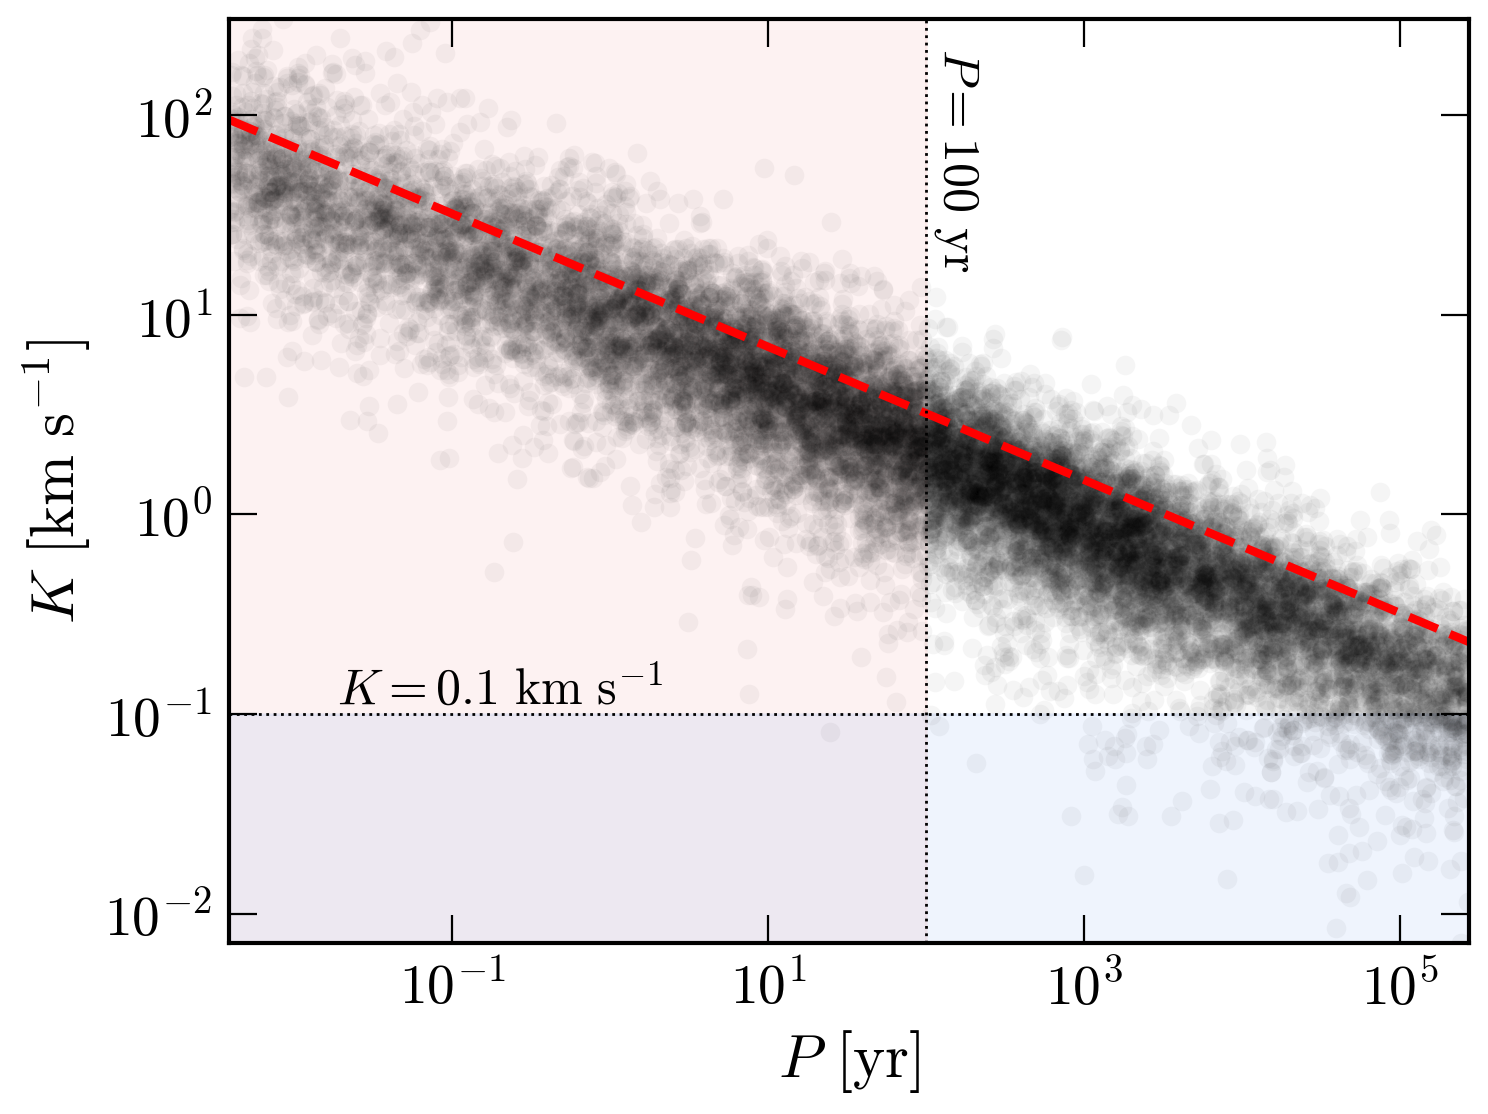

In [87]:
### period / amplitude relation -- detectability and problematic-ness...
def calc_amplitude(Mtot, M2, a, P, e, inclination):
    a1 = (M2/Mtot) * a
    num = 2*np.pi*a1 *np.sin(inclination)
    denom = P * np.sqrt(1-(e**2))
    K = num/denom
    return K

def calc_semi(Mtot, P):
    arg = (P**2 / (4*np.pi**2)) * const.G * Mtot
    return arg**(1/3)

# get model (e=0, equal mass binaries viewed edge on)
semis_model = np.logspace(-2, 4, 100000) * u.au
m1_model = 0.5 * u.Msun
m2_model = 0.5 * u.Msun
mtot_model = m1_model + m2_model
ps_model = paf.calc_P(semis_model, mtot_model)
ks_model = calc_amplitude(mtot_model, m2_model, semis_model, ps_model,
                          e=0, inclination=np.pi/2)

m1s = IBT['mass_1'].values * u.Msun
m2s = IBT['mass_2'].values * u.Msun
mtots = m1s+m2s
ps = IBT['porb'].values * u.day
semis = calc_semi(mtots, ps)
es = IBT['ecc'].values
inclinations = paf.draw_inclinations(n=len(m1s))
ks = calc_amplitude(mtots, m2s, semis, ps, es, inclinations)



fig, ax = plt.subplots(figsize=[8,6])
ax.plot(ps_model.to(u.yr), ks_model.to(u.km/u.s), c='r', ls="--")

ax.scatter(ps.to(u.yr), ks.to(u.km/u.s), c='k', alpha=0.04, s=50, linewidth=0,
           rasterized=True)
ax.set_xscale('log')
ax.set_yscale("log")


ax.set_xlim(min(ps.to(u.yr).value), max(ps.to(u.yr).value))
ax.set_ylim(min(ks.to(u.km/u.s).value), max(ks.to(u.km/u.s).value))

ax.set_xlabel(r"$P~\rm [yr]$")
ax.set_ylabel(r"$K~\rm [km\ s^{-1}]$")


ax.axvspan(1e-3, 1e2, alpha=0.1, color='lightcoral', zorder=0)
ax.axvline(100, c='k', ls=":", lw=1)
ax.text(110, 1e2-40, r"$P=100~\rm yr$",
        rotation=270, va='center', ha='left', fontsize=18)

ax.axhspan(1e-3, 1e-1, alpha=0.1, color='cornflowerblue', zorder=0)
ax.axhline(1e-1, c='k', ls=":", lw=1)
ax.text(2e-1, 1e-1, r"$K=0.1~\rm km\ s^{-1}$", ha='center', va='bottom', fontsize=18)

ax.minorticks_off()

# plt.savefig("plots/amplitude_and_detectability_context.pdf", dpi=300, bbox_inches='tight')

#### option 1:

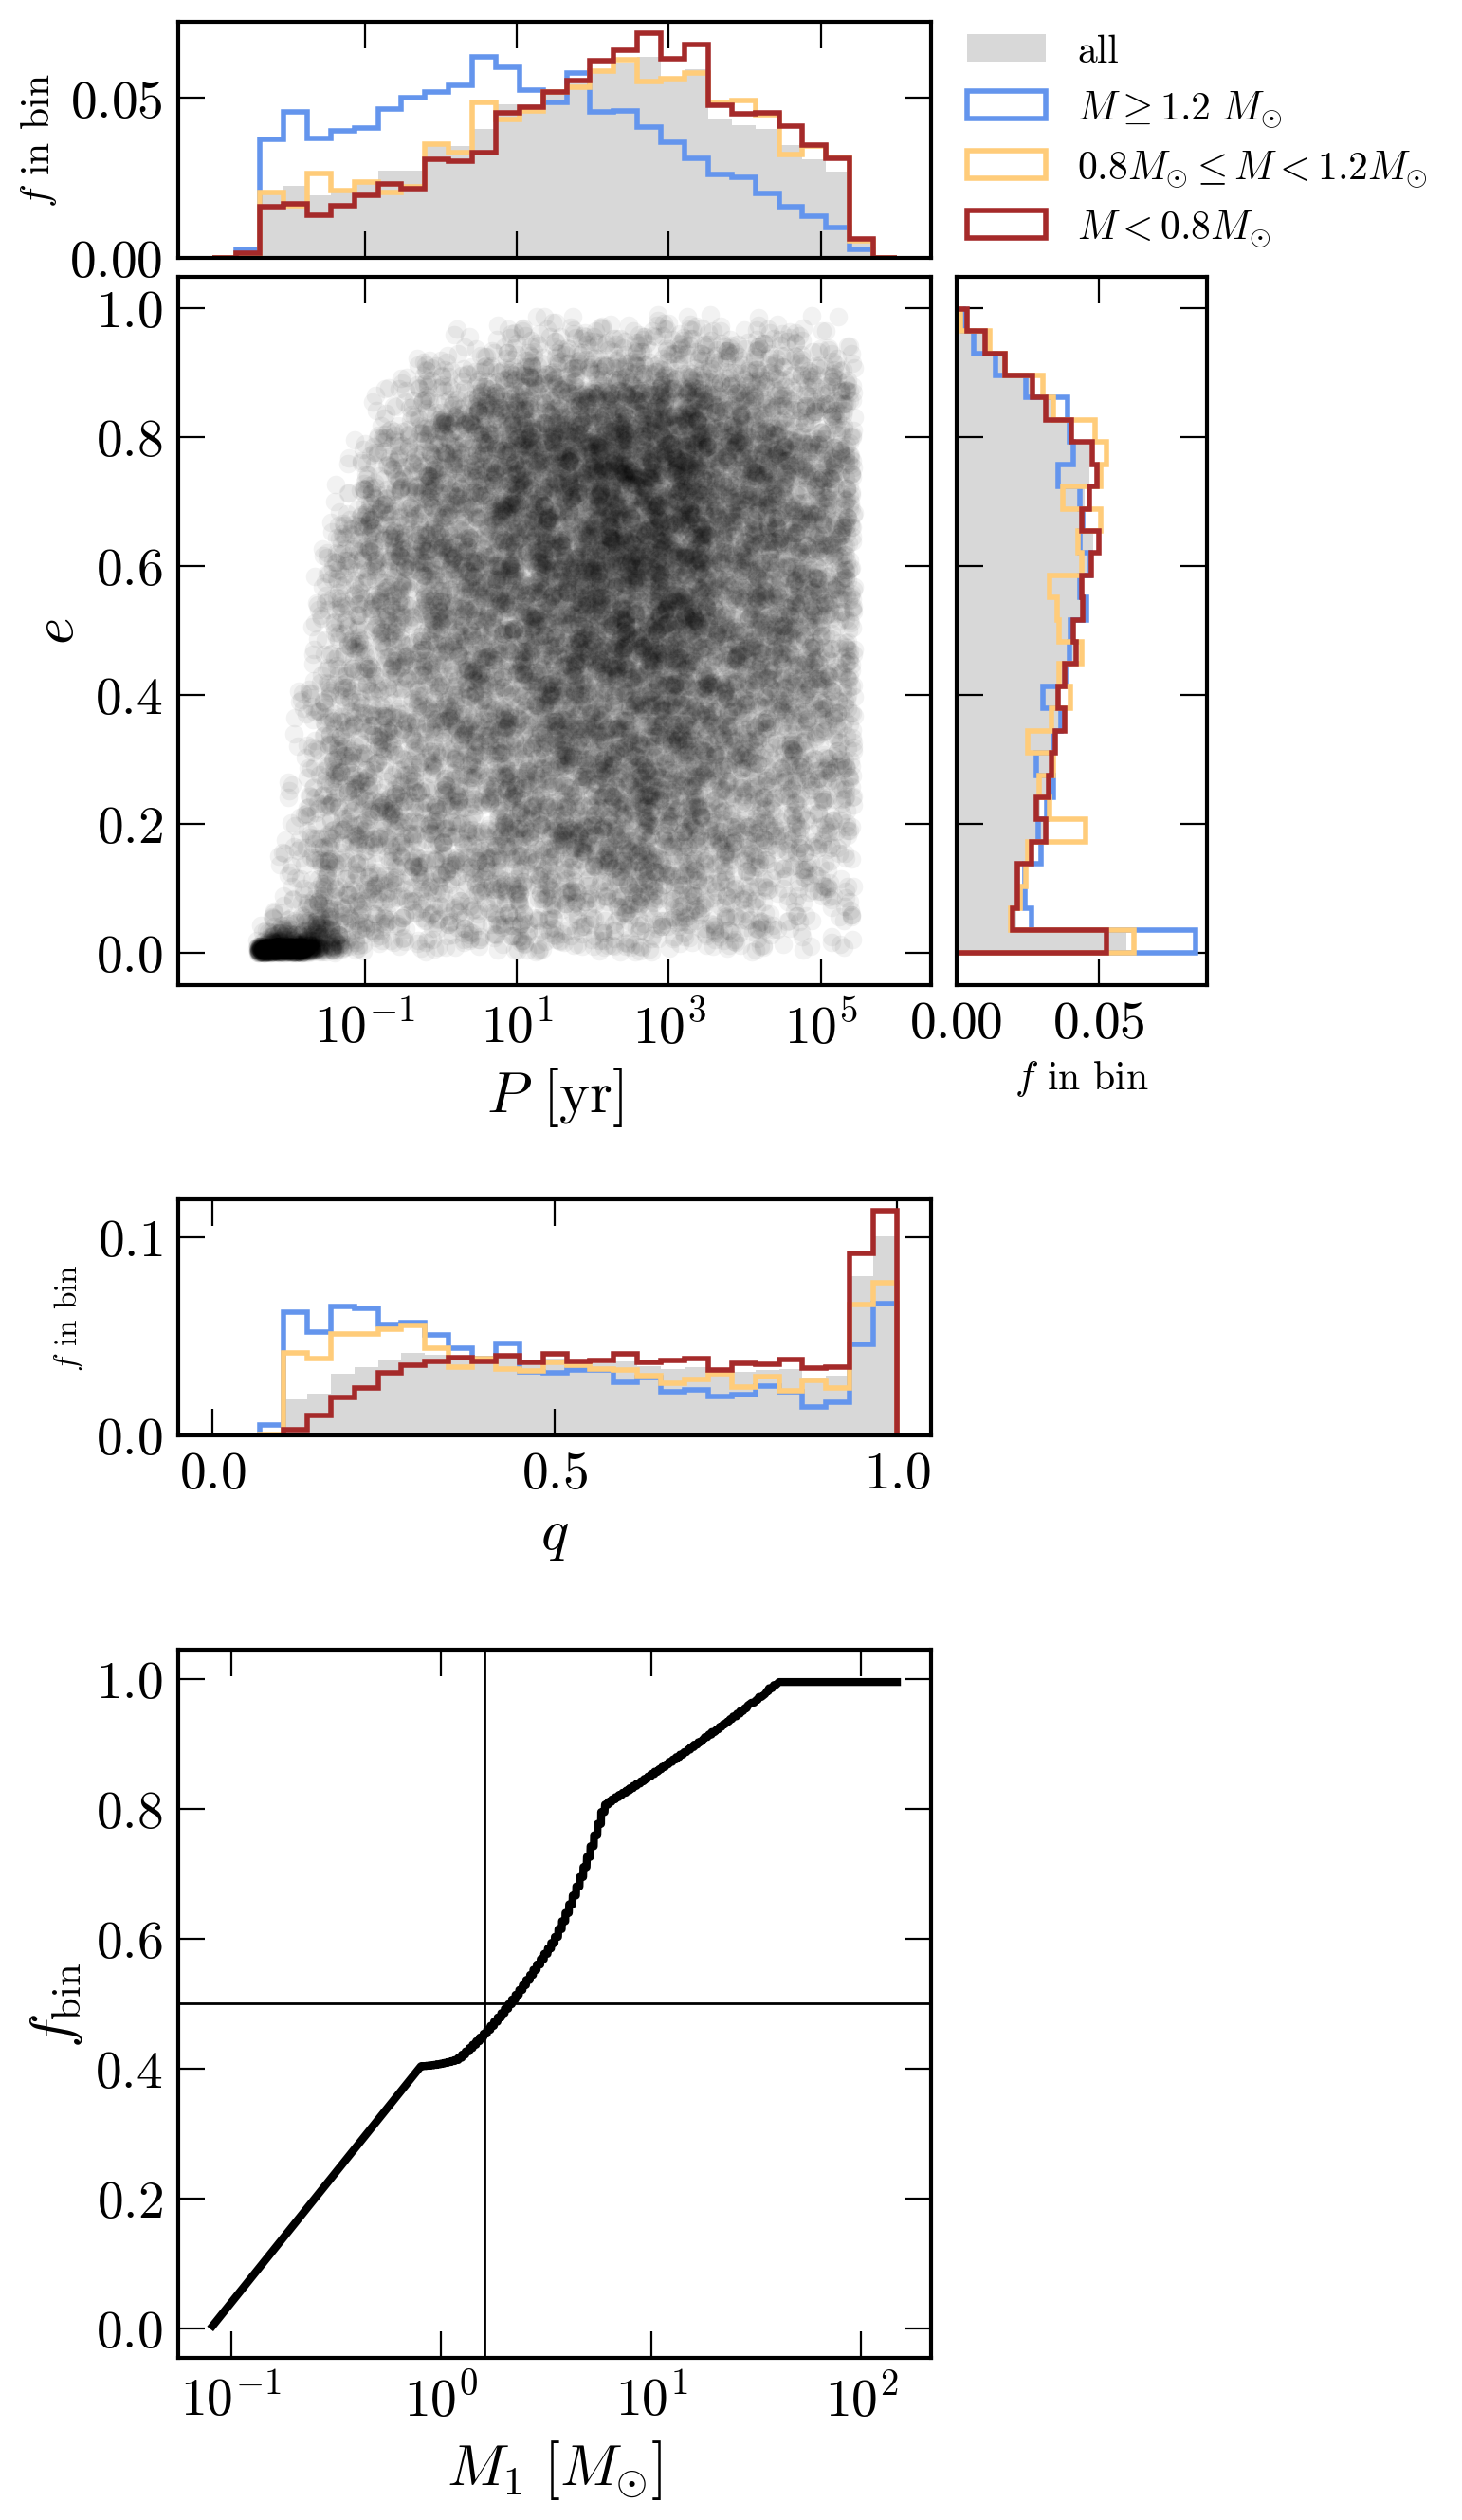

In [88]:
### option 1 for the initial binary population visualization
# includes a panel showing period vs eccentricity distribution
# but maybe we don'e care about that .
# also, whether to split_mass at 1.2 or 1.6 Msun -- have done 1.6 in the doubled fbin sims but 1.2 makes more sense
# given the piecewise definitions from moe & distefano,
m = mtots.to(u.Msun).value
a = semis
P = ps
m1 = m1s.to(u.Msun).value
m2 = m2s.to(u.Msun).value
mass_ratio = np.minimum(m1,m2)/ np.maximum(m1, m2)

primary_masses = np.maximum(m1, m2)


# mass cuts
split_mass = 1.2 # or 1.6 <- misleading? 
Mdwarf_cut = 0.8 # 0.45 from my shu notes / 0.8 is where M&D stop so this is what I'm using.
select_OBA = primary_masses>=split_mass
select_FGK = (primary_masses<split_mass) & (primary_masses>=Mdwarf_cut)
select_M = primary_masses<Mdwarf_cut

# copy-pasting the one from petar's documentation
from matplotlib import gridspec
# fig = plt.figure(figsize=(7,9)) 
# gs = fig.add_gridspec(4, 2, width_ratios=[3, 1], height_ratios=[1, 3,0.75,1]) 

fig = plt.figure(figsize=(7,16)) 
gs = fig.add_gridspec(6, 2, width_ratios=[3, 1], height_ratios=[1, 3,0.75,1, 0.75, 3]) 


axexy = fig.add_subplot(gs[1,0])
axehx = fig.add_subplot(gs[0,0],sharex=axexy)
axehy = fig.add_subplot(gs[1,1],sharey=axexy)

axmass = fig.add_subplot(gs[3, :-1])


axehx.tick_params(labelbottom=False)  # hides x tick labels
axehy.tick_params(labelleft=False)    # hides y tick labels
plt.subplots_adjust(hspace=0.05,wspace=0.05)

xlim=[1e-3,1e6]
ylim=[0,0.999]
axehx.set_xscale('log')
axexy.set_xlabel(r'$P$ [yr]')
axexy.set_ylabel(r'$e$')
axexy.set_xticks([1e-1,1e1,1e3,1e5])

nbinx=30
nbiny=30
log_xbins=np.logspace(np.log10(xlim[0]),np.log10(xlim[1]), nbinx)
ybins=np.linspace(ylim[0], ylim[1], nbiny)

x = P.to(u.yr).value
y = es


axehx.hist(x, bins=log_xbins,color='grey', alpha=0.3, linewidth=2, weights=np.ones(x.size)/x.size,
           label='all')#,
        #    weights=np.ones(x.size)/x.size,label='Initial')
axehx.hist(x[select_OBA], bins=log_xbins, histtype='step', color='cornflowerblue', weights=np.ones(x[select_OBA].size)/x[select_OBA].size,
                linewidth=2, label=r"$M\geq%.1f\ M_{\odot}$"%split_mass)
axehx.hist(x[select_FGK], bins=log_xbins, histtype='step', color=simcolors[-1], weights=np.ones(x[select_FGK].size)/x[select_FGK].size,
                linewidth=2, label=r"$0.8 M_{\odot} \leq M < %.1f M_{\odot}$"%split_mass)
axehx.hist(x[select_M], bins=log_xbins, histtype='step', color='brown', weights=np.ones(x[select_M].size)/x[select_M].size,
                linewidth=2, label=r"$M<0.8 M_{\odot}$")
axehx.set_ylabel(r'$f$ in bin', fontsize=15)
axehx.legend(bbox_to_anchor=[1,1.1], fontsize=15)

axehy.hist(y, bins=ybins,orientation="horizontal",color='grey', alpha=0.3, 
           weights=np.ones(x.size)/x.size)
axehy.hist(y[select_OBA], bins=ybins, histtype='step', color='cornflowerblue', weights=np.ones(y[select_OBA].size)/y[select_OBA].size,
                linewidth=2, label=r"$M\geq1.6\ M_{\odot}$", orientation='horizontal')
axehy.hist(y[select_FGK], bins=ybins, histtype='step', color=simcolors[-1], weights=np.ones(y[select_FGK].size)/y[select_FGK].size,
                linewidth=2, label=r"$0.8 M_{\odot} \leq M < 1.6 M_{\odot}$", orientation='horizontal')
axehy.hist(y[select_M], bins=ybins, histtype='step', color='brown', weights=np.ones(y[select_M].size)/y[select_M].size,
                linewidth=2, label=r"$M<0.8 M_{\odot}$", orientation='horizontal')


axehy.set_xlabel(r'$f$ in bin', fontsize=15)
pt = axexy.scatter(x ,y, #s=1.5*mtots, 
                   c='k', alpha=0.05, s=50, linewidth=0,
                # c=IBT['binfrac'], cmap='magma', alpha=0.5,
                   rasterized=True) #, c=mass_ratio)


axmass.hist(mass_ratio, bins=np.linspace(0,1,30), color='gray', alpha=0.3, linewidth=2,
            weights = np.ones(mass_ratio.size)/mass_ratio.size)
axmass.hist(mass_ratio[select_OBA], bins=np.linspace(0,1,30), histtype='step', color='cornflowerblue', weights=np.ones(mass_ratio[select_OBA].size)/mass_ratio[select_OBA].size,
                linewidth=2, label=r"$M\geq1.6\ M_{\odot}$")
axmass.hist(mass_ratio[select_FGK], bins=np.linspace(0,1,30), histtype='step', color=simcolors[-1], weights=np.ones(mass_ratio[select_FGK].size)/mass_ratio[select_FGK].size,
                linewidth=2, label=r"$0.8 M_{\odot} \leq M < 1.6 M_{\odot}$")
axmass.hist(mass_ratio[select_M], bins=np.linspace(0,1,30), histtype='step', color='brown', weights=np.ones(mass_ratio[select_M].size)/mass_ratio[select_M].size,
                linewidth=2, label=r"$M<0.8 M_{\odot}$")

axmass.set_xlabel(r'$q$')
axmass.set_ylabel(r'$f$ in bin', fontsize=12)

axfbin = fig.add_subplot(gs[-1, :-1])#0:])
sorted_inds = np.argsort(IBT['mass_1'].values)
axfbin.plot(IBT['mass_1'][sorted_inds], IBT['binfrac'][sorted_inds], c='k')
axfbin.set_xscale('log')
axfbin.set_xlabel(r'$M_1~[M_{\odot}]$')
axfbin.set_ylabel(r'$f_{\rm bin}$')

axfbin.axvline(1.6, lw=1, c='k')
axfbin.axhline(0.5, c='k', lw=1)

for ax in [axexy,axehx,axehy,axmass,axfbin]:
    ax.minorticks_off()

# plt.savefig("plots/initial_binary_pop_bigsample.pdf", dpi=300, bbox_inches='tight')

#### option 2:

In [ ]:
from scipy.ndimage import gaussian_filter1d

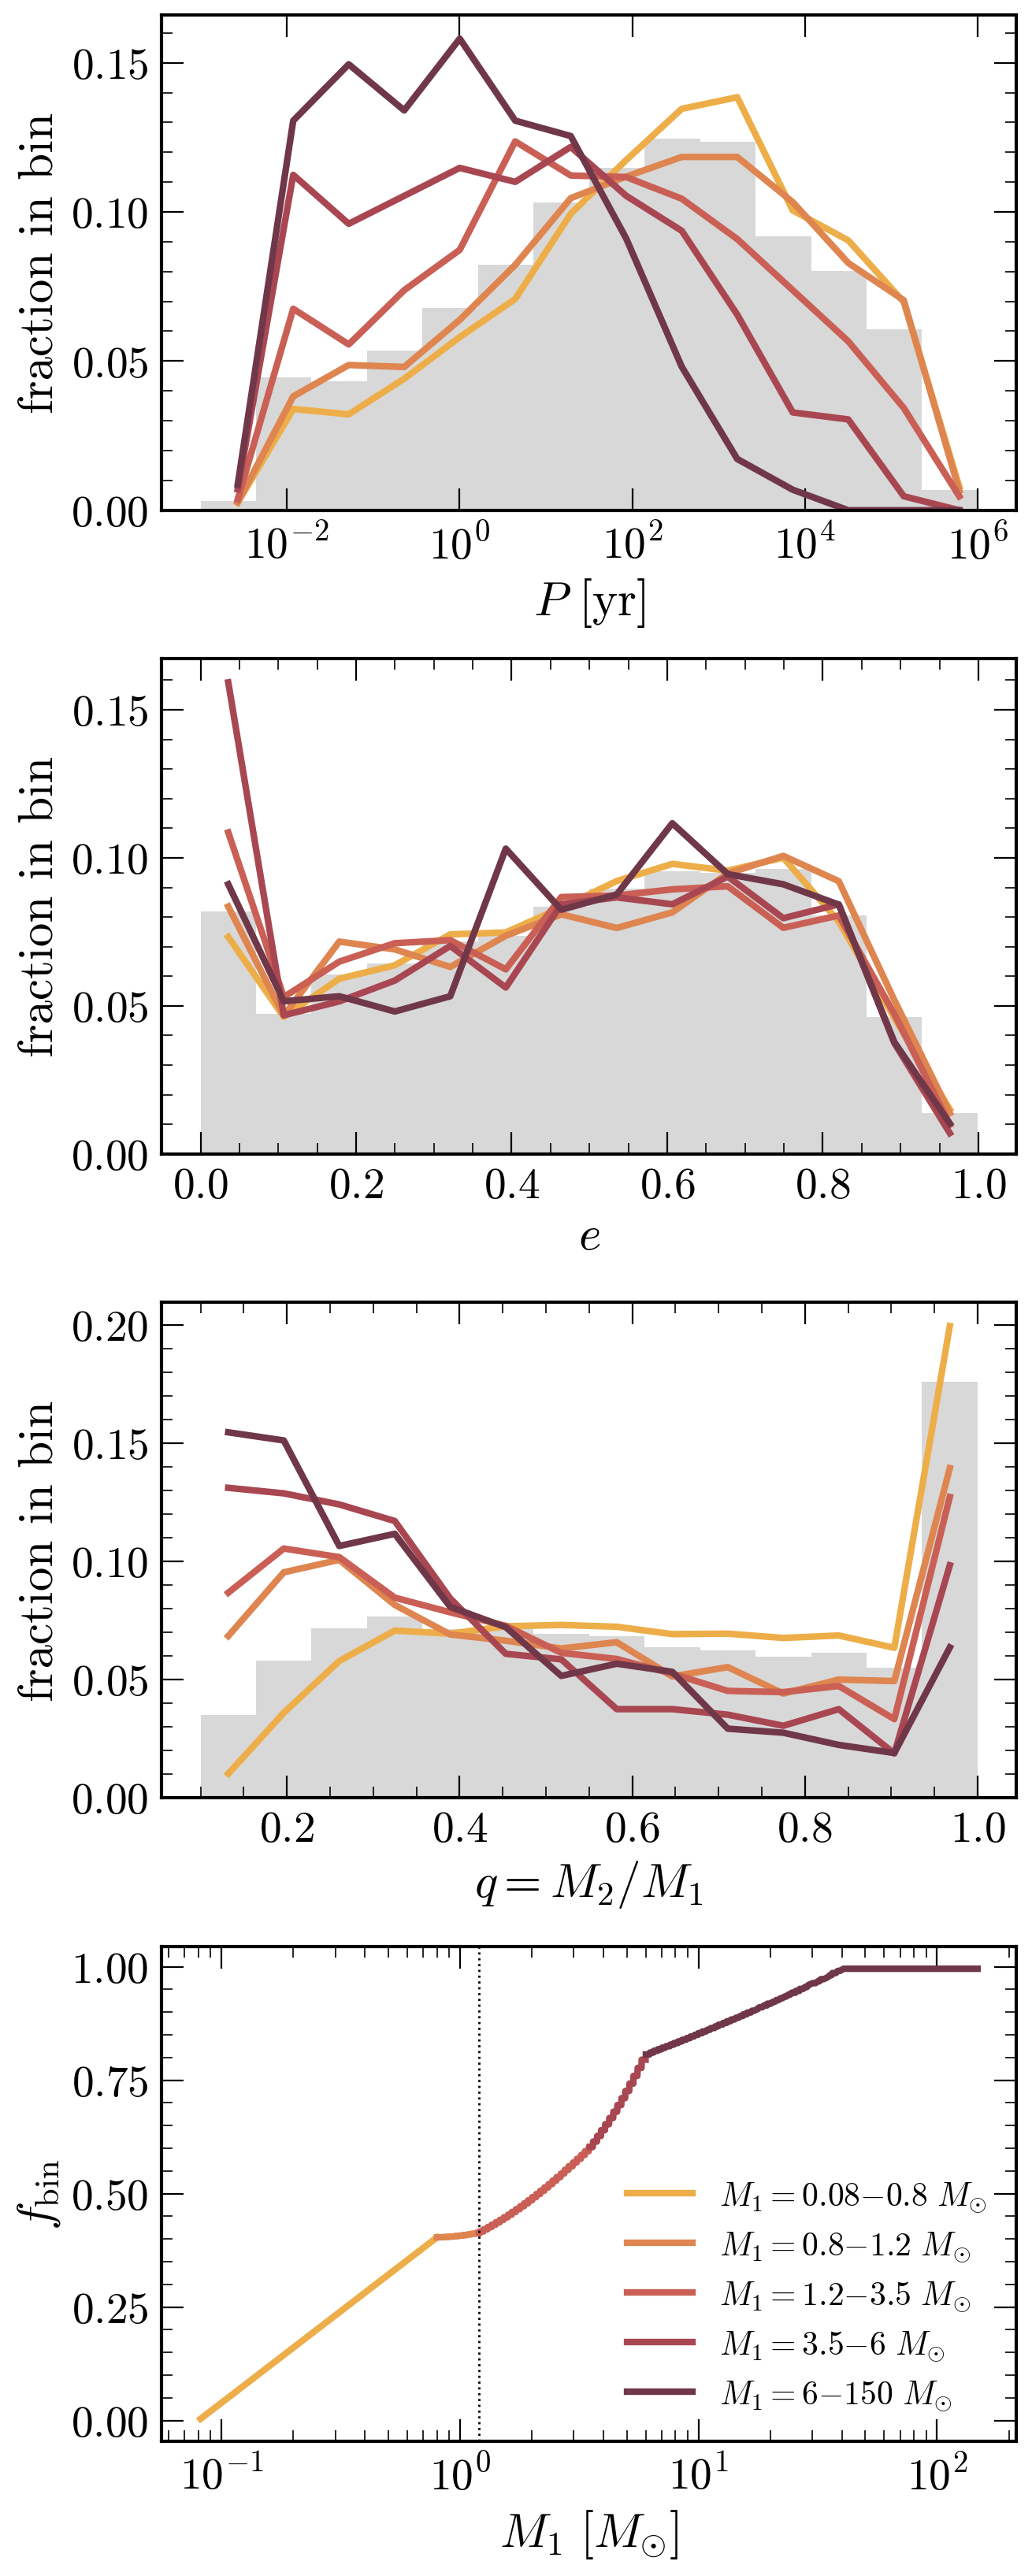

In [90]:
# alt version: just histograms and I show many mass cuts?
# the initial binary population vis.
m = mtots.to(u.Msun).value
a = semis
P = ps
m1 = m1s.to(u.Msun).value
m2 = m2s.to(u.Msun).value
mass_ratio = np.minimum(m1,m2)/ np.maximum(m1, m2)
es = IBT['ecc'].values
fbins = IBT['binfrac'].values

primary_masses = np.maximum(m1, m2)


# split_masses = np.concatenate([
#     0.08*np.ones(1), np.arange(0.8, 8.4, 0.4), np.max(primary_masses)*np.ones(1)
# ])

# assign split_masses based on the piecewise definitions of gamma_largeq, gamma_smallq, which implicitly 
# determine the period distributions & binary fractions as a function of primary mass. 
split_masses = np.array([0.08, 0.8, 1.2, 3.5, 6.0, 150]) # np.max(primary_masses)])

split_labels = [r"$M_1 = %.1f\mathrm{-}%.1f~M_{\odot}$"%(split_masses[i-1], split_masses[i]) for i in range(1, len(split_masses))]
split_labels[0] = r"$M_1 = %.2f\mathrm{-}%.1f~M_{\odot}$"%(split_masses[0], split_masses[1])
split_labels[-2] = r"$M_1 = %.1f\mathrm{-}%i~M_{\odot}$"%(split_masses[-3], split_masses[-2])
split_labels[-1] = r"$M_1 = %i\mathrm{-}%i~M_{\odot}$"%(split_masses[-2], split_masses[-1])

# split_labels = [r"$%.1f~M_{\odot}\leq M_1< %.1f \ M_{\odot}$"%(split_masses[i-1], split_masses[i]) for i in range(1, len(split_masses))]
# split_labels[0]= r"$%.2f~M_{\odot}\leq M_1< %.1f \ M_{\odot}$"%(split_masses[0], split_masses[1])
# split_labels[-2] = r"$%.1f~M_{\odot}\leq M_1< %i \ M_{\odot}$"%(split_masses[-3], split_masses[-2])
# split_labels[-1] = r"$%i~M_{\odot}\leq M_1< %i \ M_{\odot}$"%(split_masses[-2], split_masses[-1])


colors=["#212738","#4D3041","#79394A","#994250","#B24B54","#C55756","#D26A54","#DC8051","#E5974D","#EDAE49"]
colors.reverse()
time_cmap = LinearSegmentedColormap.from_list('time_cmap', colors)
colors = time_cmap(np.linspace(0, 1, len(split_masses)))

xlabels = [r"$P\ [\rm yr]$", r"$e$", r"$q = M_2/M_1$", r"$M_1\ [M_{\odot}]$"]
hist_vals = [ps.to(u.yr).value, es, mass_ratio, fbins]
bins = [np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), nbinx-15),
        np.linspace(ylim[0], ylim[1], nbiny-15),
        np.linspace(0.1,1,nbinx-15),
        None
        ]

fig, axs = plt.subplots(len(hist_vals),1,figsize=[7,(5*(len(hist_vals)))])
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[0].set_xscale('log')
for i in range(1, len(split_masses)): # outer loop: through primary mass ranges

    crit = (primary_masses>=split_masses[i-1]) & (primary_masses<split_masses[i])

    for j in range(len(axs)):
        # print(j)
        ax = axs[j]
        ax.set_xlabel(xlabels[j])
        
        x = hist_vals[j]
        b = bins[j]
        if i==1:
            if j<3:
                ax.hist(x, bins=b, color='gray', alpha=0.3, 
                        weights = np.ones(x.size)/x.size, label='all binaries')
        
        if j in [0,1,2]:
            bc = (b[1:]+b[:-1])/2 # bin centers
            hist, _ = np.histogram(x[crit], bins=b, weights = np.ones(x[crit].size)/x[crit].size)
            # hist_smooth = gaussian_filter1d(hist, sigma = 5*np.diff(b)[0])
            hist_smooth=hist
            ax.plot(bc, hist_smooth, color=colors[i-1])
        if j==3:
            sorted_inds = np.argsort(primary_masses[crit])
            ax.plot(primary_masses[crit][sorted_inds],
                    fbins[crit][sorted_inds], color=colors[i-1], 
                    label = split_labels[i-1]) #r"$%.2f~M_{\odot}\leq M_1< %.1f \ M_{\odot}$"%(split_masses[i-1], split_masses[i]))


            

axs[0].set_xscale('log')
axs[-1].set_xscale('log')
axs[-1].set_ylabel(r'$f_{\rm bin}$')
axs[-1].legend(loc='lower right', fontsize=15)

axs[-1].axvline(1.2, c='k', ls=":", lw=1)
for ax in axs[:-1]:
    ax.set_ylabel(r"fraction in bin")

plt.savefig("plots/initial_binary_demographics_MD.pdf", dpi=300, bbox_inches='tight')

#### option 3

/var/folders/q2/m18s57611677cjnvtmvry2v80000gn/T/ipykernel_43763/482881492.py:33: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axsc.scatter(periods[crit], eccs[crit], c=colors[i], rasterized=True)
/var/folders/q2/m18s57611677cjnvtmvry2v80000gn/T/ipykernel_43763/482881492.py:33: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axsc.scatter(periods[crit], eccs[crit], c=colors[i], rasterized=True)
/var/folders/q2/m18s57611677cjnv

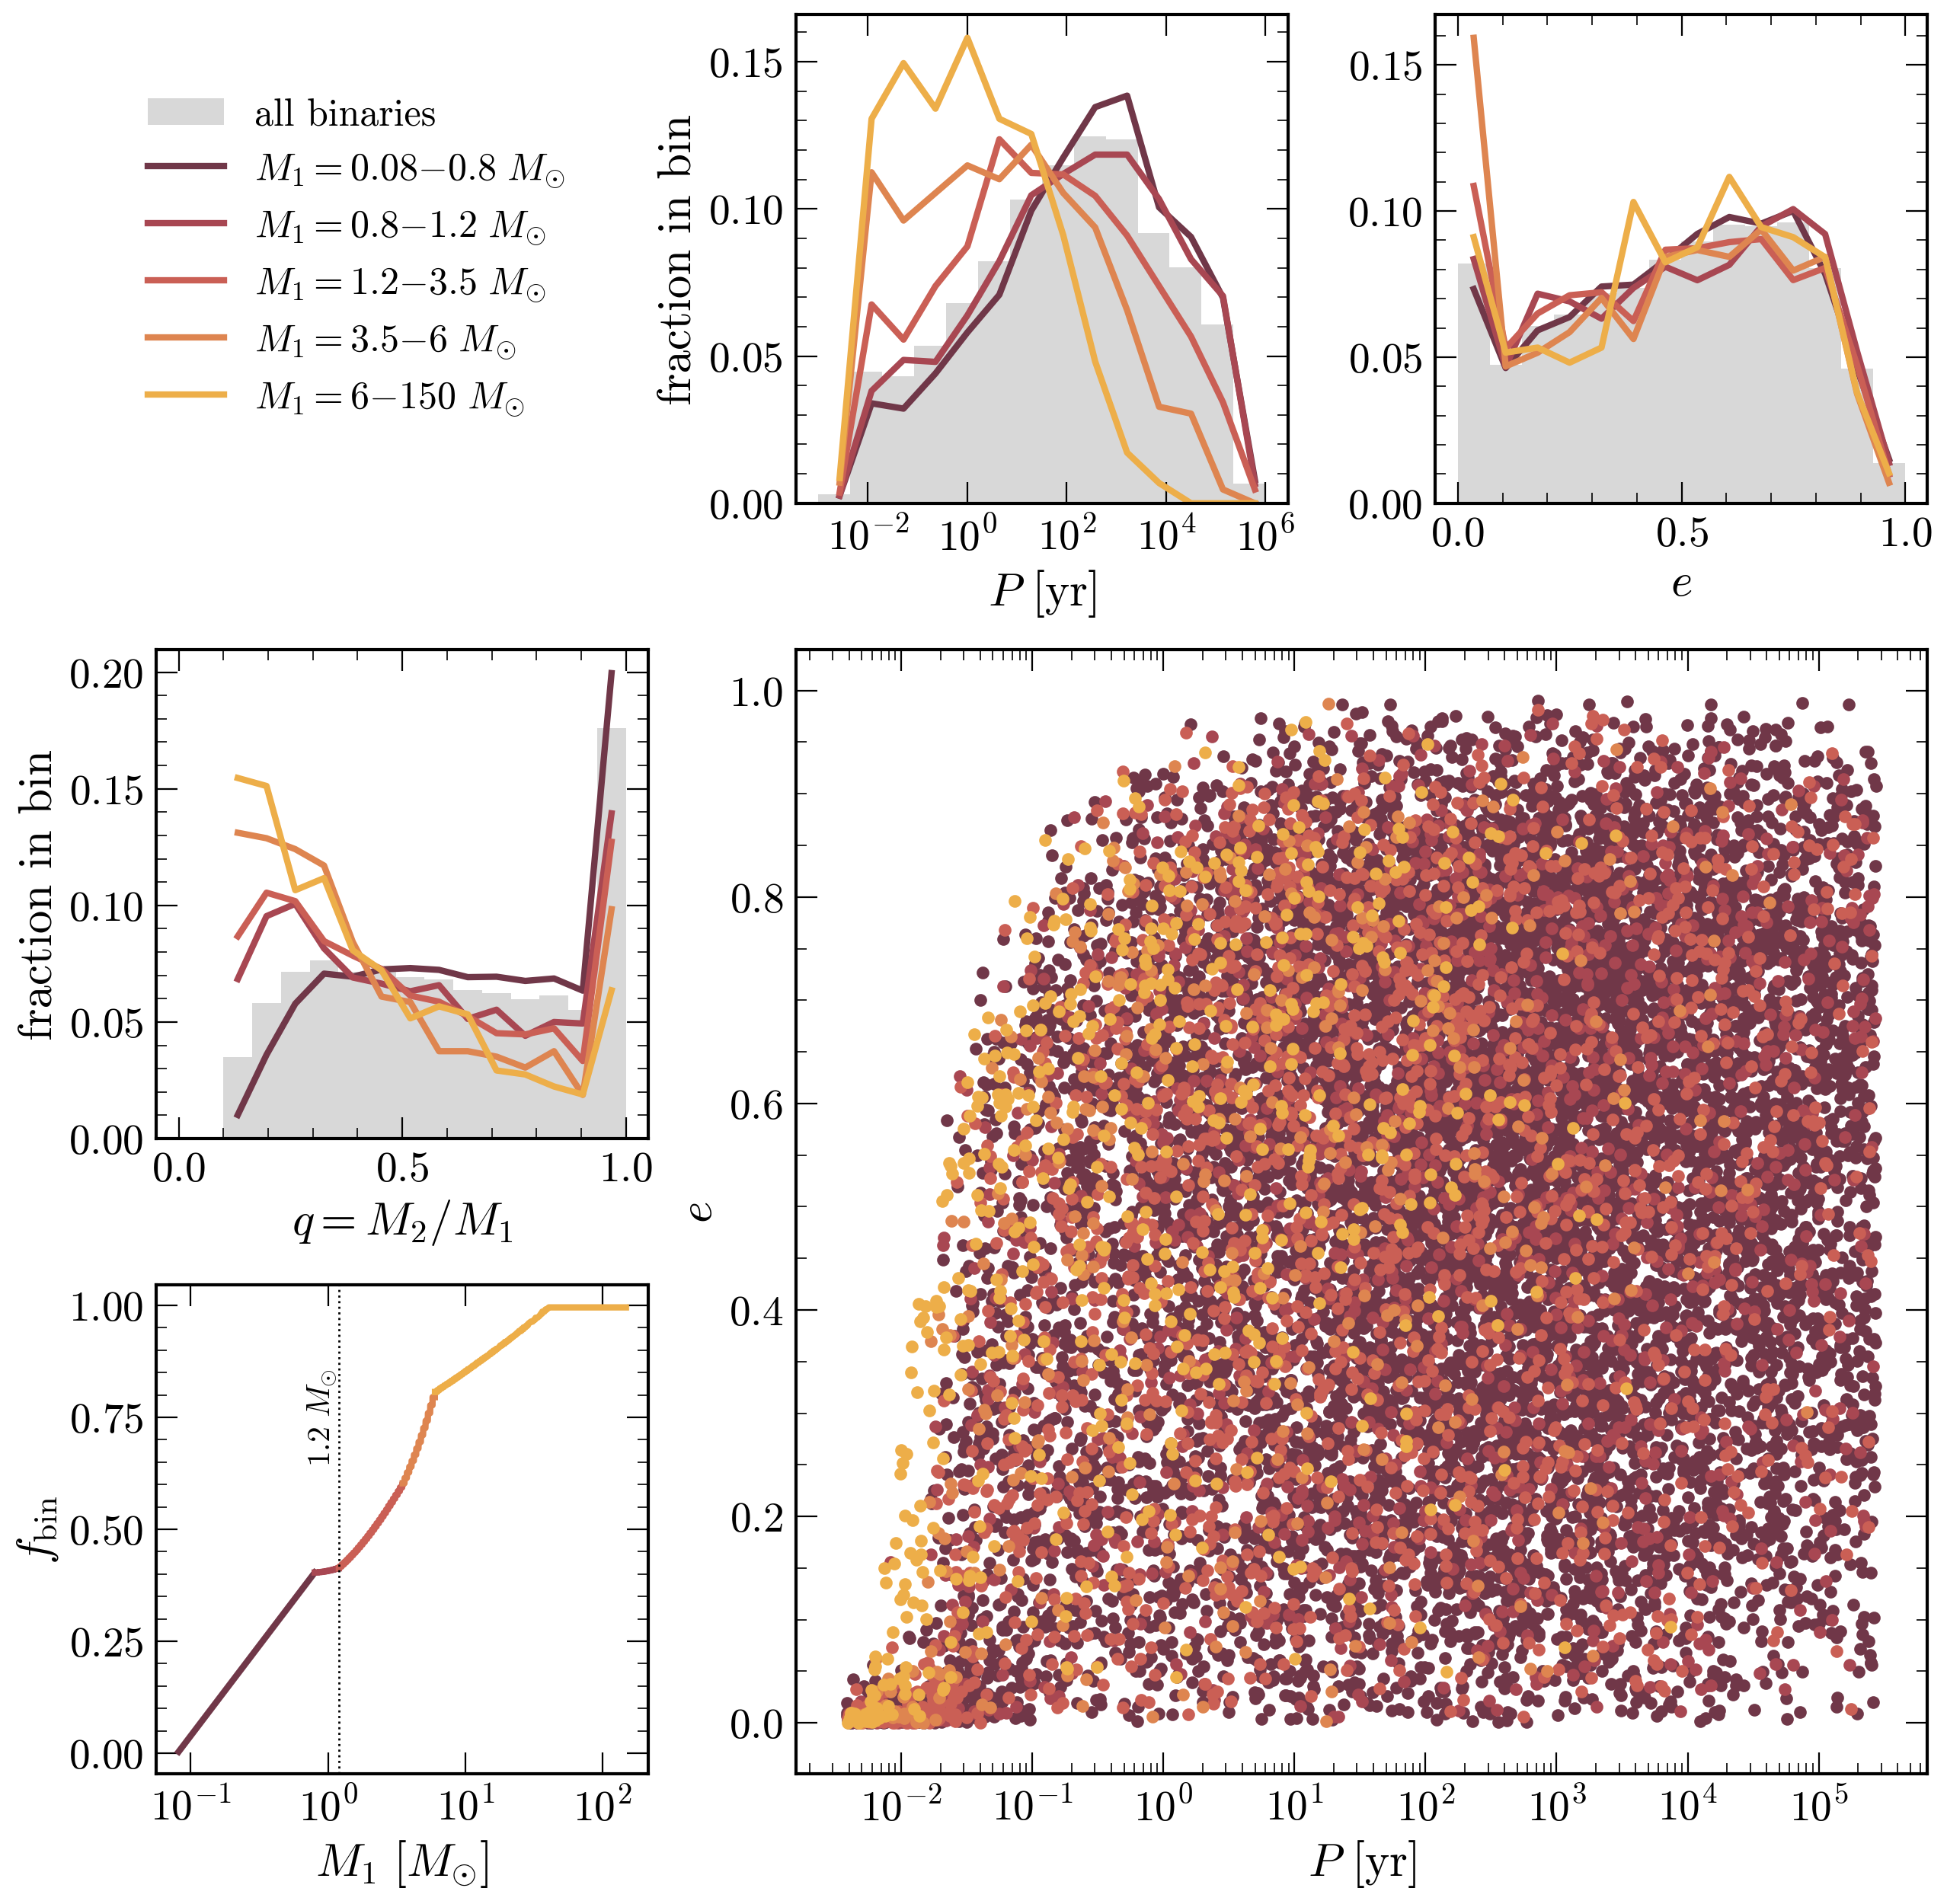

In [91]:
#### okay and now just because I can, a gridspec one that has a square panel 
# with the period/eccentricity distribution as well 
# with the color code and everything. 

colors=["#212738","#4D3041","#79394A","#994250","#B24B54","#C55756","#D26A54","#DC8051","#E5974D","#EDAE49"]
# colors.reverse()
time_cmap = LinearSegmentedColormap.from_list('time_cmap', colors)
colors = time_cmap(np.linspace(0, 1, len(split_masses)))

fig = plt.figure(figsize=(15,15)) 
gs = fig.add_gridspec(3, 3, width_ratios=[1,1,1], height_ratios=[1, 1, 1]) 
plt.subplots_adjust(wspace=0.3, hspace=0.3)

ax0 = fig.add_subplot(gs[0,1])
ax1 = fig.add_subplot(gs[0,2])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

axsc = fig.add_subplot(gs[1:,1:])
axsc.set_xscale('log')
axsc.set_xlabel(r"$P\ [\rm yr]$")
axsc.set_ylabel(r'$e$')

axs = [ax0,ax1,ax2,ax3]

axs[0].set_xscale('log')
for i in range(1, len(split_masses)): # outer loop: through primary mass ranges

    crit = (primary_masses>=split_masses[i-1]) & (primary_masses<split_masses[i])

    periods = hist_vals[0]
    eccs = hist_vals[1]
    axsc.scatter(periods[crit], eccs[crit], c=colors[i], rasterized=True)

    for j in range(len(axs)):
        # print(j)
        
        
        ax = axs[j]
        ax.set_xlabel(xlabels[j])
        
        x = hist_vals[j]
        b = bins[j]
        
        if i==1:
            if j<3:
                ax.hist(x, bins=b, color='gray', alpha=0.3, 
                        weights = np.ones(x.size)/x.size, label='all binaries')
        
        if j in [0,1,2]:
            bc = (b[1:]+b[:-1])/2 # bin centers
            hist, _ = np.histogram(x[crit], bins=b, weights = np.ones(x[crit].size)/x[crit].size)
            # hist_smooth = gaussian_filter1d(hist, sigma = 5*np.diff(b)[0])
            hist_smooth=hist
            ax.plot(bc, hist_smooth, color=colors[i], label=split_labels[i-1])
        if j==3:
            sorted_inds = np.argsort(primary_masses[crit])
            ax.plot(primary_masses[crit][sorted_inds],
                    fbins[crit][sorted_inds], color=colors[i], 
                    label = split_labels[i-1]) #r"$%.2f~M_{\odot}\leq M_1< %.1f \ M_{\odot}$"%(split_masses[i-1], split_masses[i]))


            

axs[0].set_xscale('log')
axs[-1].set_xscale('log')
axs[-1].set_ylabel(r'$f_{\rm bin}$')
axs[0].legend(fontsize=18, bbox_to_anchor=[-0.4,0.9])

axs[-1].axvline(1.2, c='k', ls=":", lw=1)
for ax in [ax0,ax2]:
    ax.set_ylabel(r"fraction in bin")

ax2.set_xlim(-0.05, 1.05)
ax0.set_xticks([1e-2, 1e0, 1e2, 1e4, 1e6])
ax3.set_xticks([1e-1,1e0,1e1,1e2])
ax3.text(1.18, 0.75, r"$1.2~M_{\odot}$", ha='right', va='center', rotation='vertical', fontsize=15)

plt.savefig('plots/initial_binary_demographics_MD_square.pdf', dpi=300, bbox_inches='tight')

#### option 4

-> using this one for the paper; come back and load a larger COSMIC population instead. 

/tmp/ipykernel_1733374/2838116637.py:77: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axsc.scatter(ps[subset_for_scatter][crit_sub], es[subset_for_scatter][crit_sub], c=colors[i], s=75, alpha=0.9, linewidth=3, rasterized=True)
/tmp/ipykernel_1733374/2838116637.py:77: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axsc.scatter(ps[subset_for_scatter][crit_sub], es[subset_for_scatter][crit_sub], c=colors[i], s=75, alpha=0.9, li

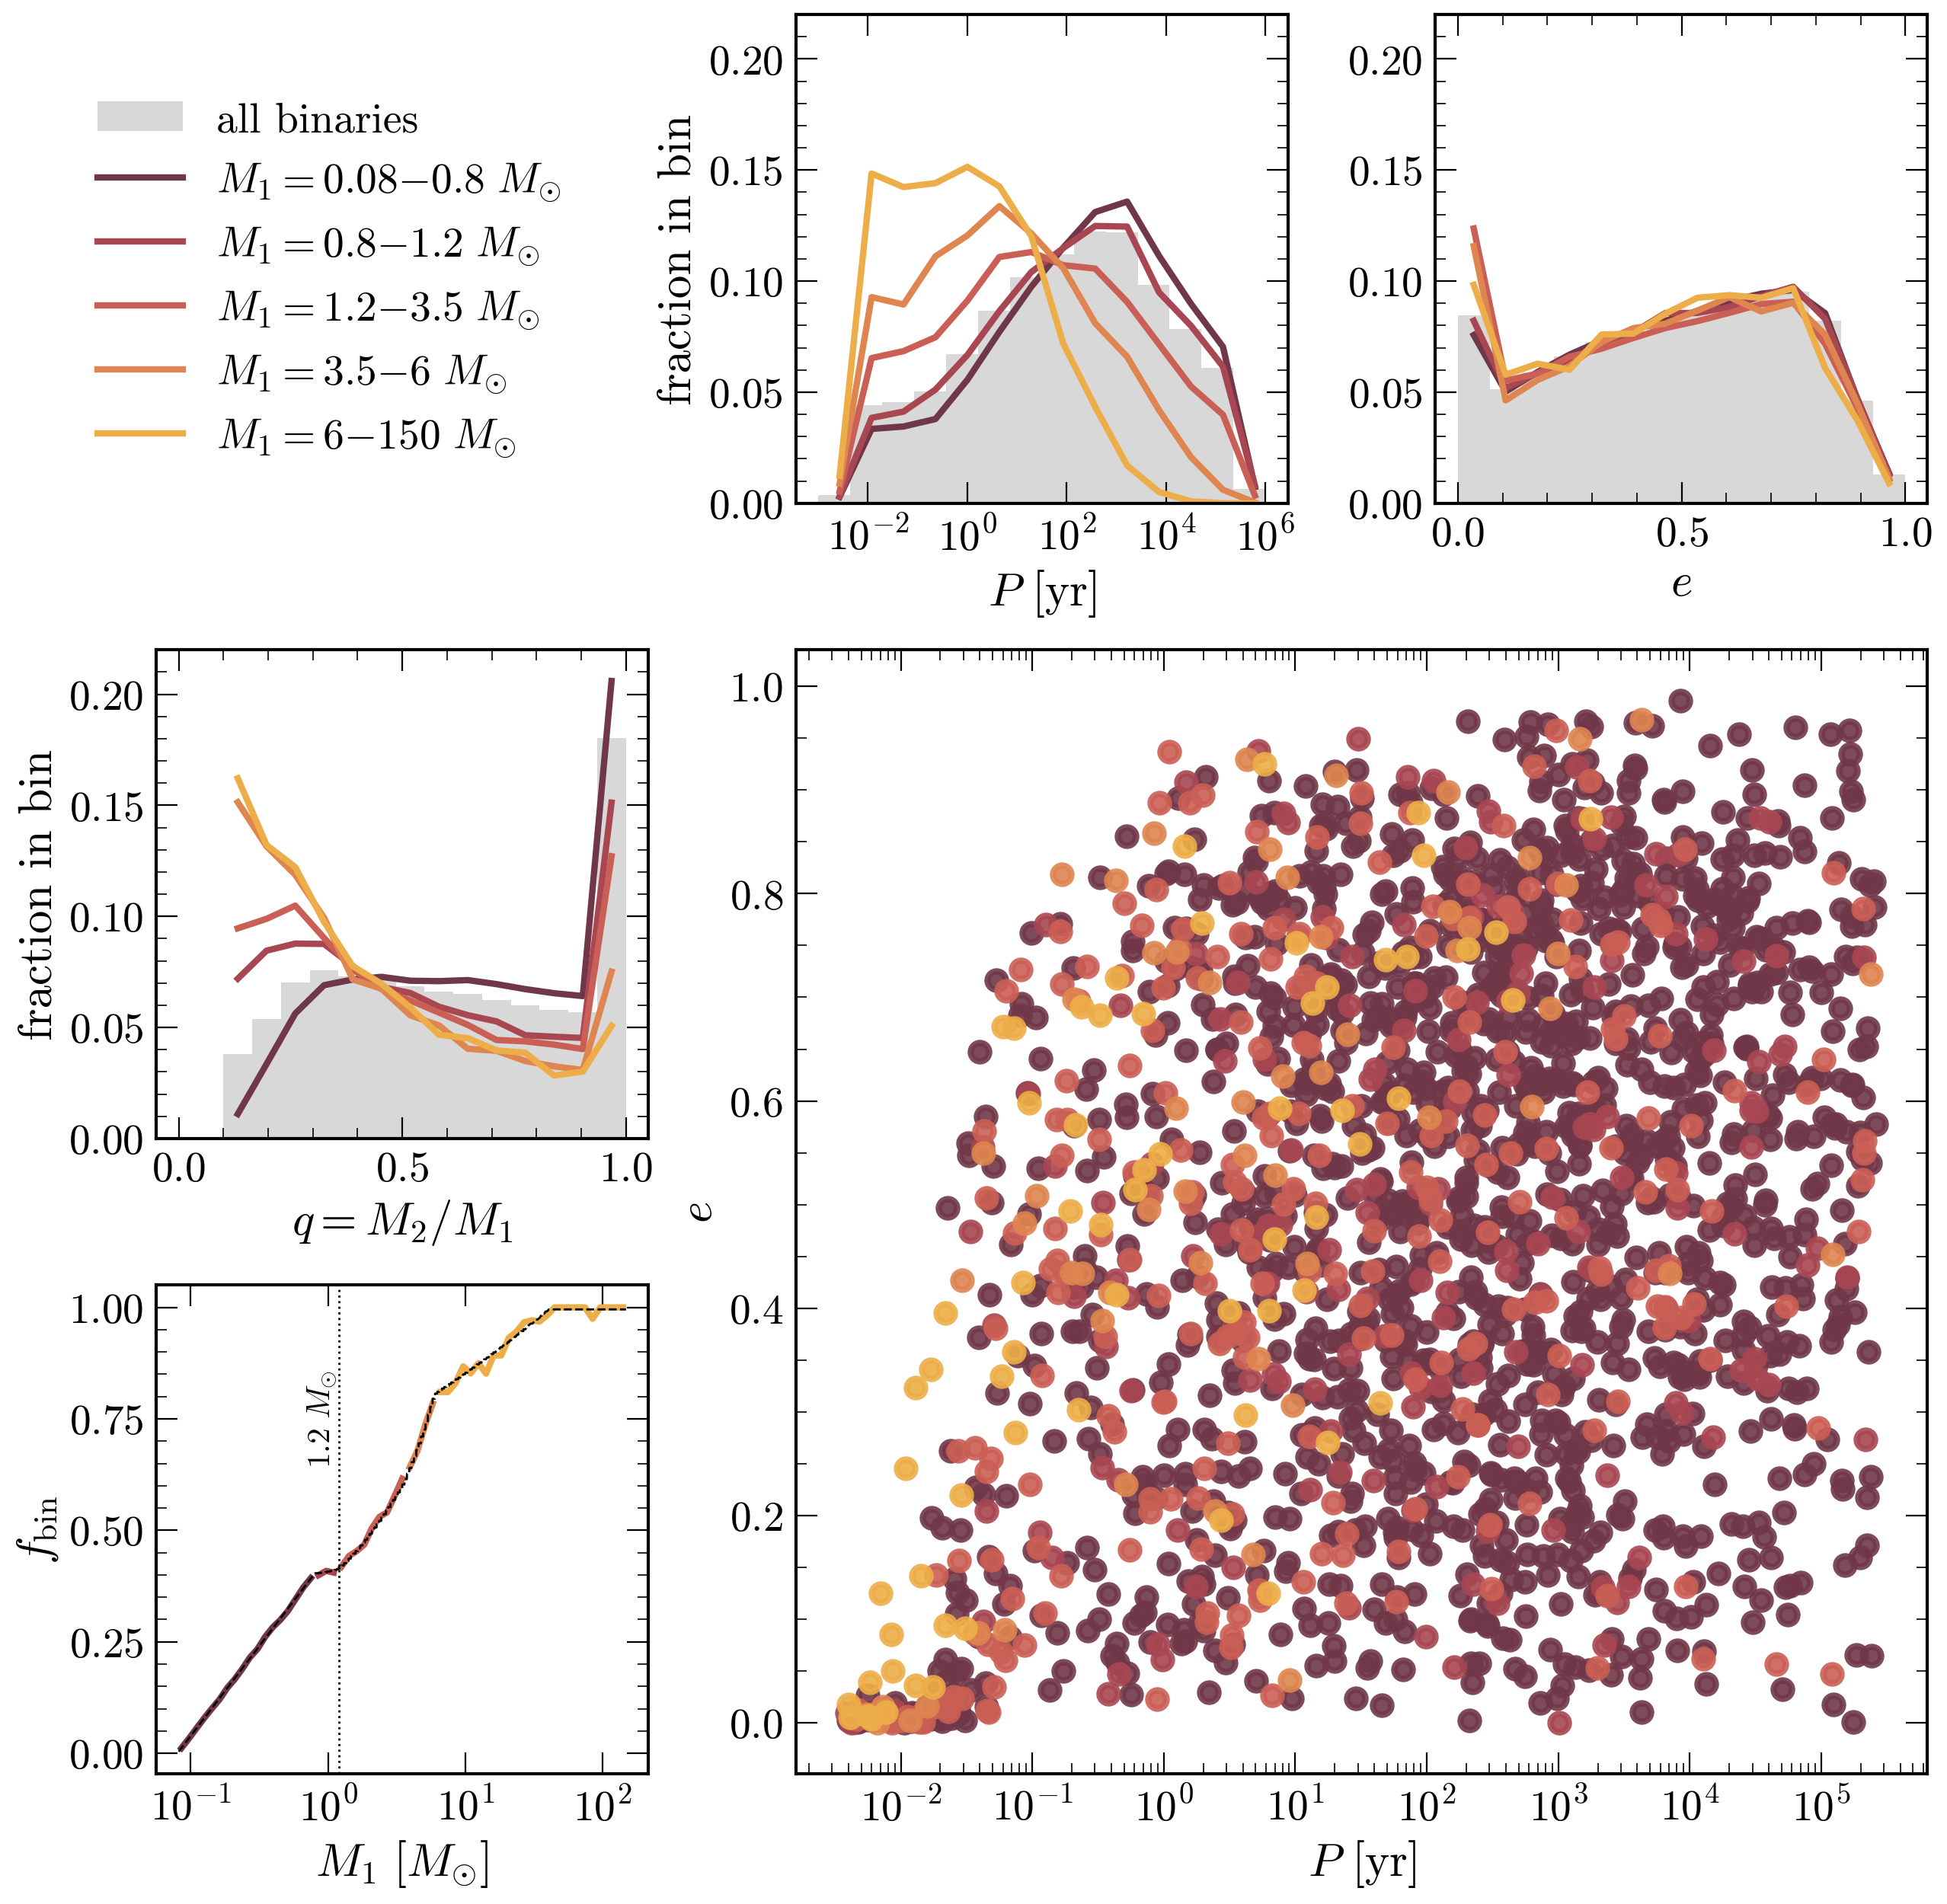

In [30]:
# dat = np.load("/n/home02/amphillips/p26/data/initial_conditions/lowmass.npz")
dat = np.load("/n/home02/amphillips/p26/data/large_COSMIC_stellar_pop.npz") # generated example for visualizing the binary statistics.
# dat.keys()

m1s = dat['primary_masses']
primary_masses = m1s
m2s = dat['secondary_masses']
qs = m2s/m1s
ps = dat['periods'] * u.day.to(u.yr)
es = dat['es']

single_masses = dat['all_CMs'][len(m1s):]

bb = np.logspace(np.log10(0.08), np.log10(150), 60)
binary_indicators = np.concatenate([np.ones(len(m1s)), np.zeros(len(single_masses))])
masses = np.concatenate([m1s, single_masses])
bbcs = (bb[:-1] + bb[1:]) / 2
fbins_lm, bin_edges, binnumbers = binned_statistic(masses, values=binary_indicators, statistic='mean', bins=bb)



split_masses = np.array([0.08, 0.8, 1.2, 3.5, 6.0, 150]) # np.max(primary_masses)])
split_labels = [r"$M_1 = %.1f\mathrm{-}%.1f~M_{\odot}$"%(split_masses[i-1], split_masses[i]) for i in range(1, len(split_masses))]
split_labels[0] = r"$M_1 = %.2f\mathrm{-}%.1f~M_{\odot}$"%(split_masses[0], split_masses[1])
split_labels[-2] = r"$M_1 = %.1f\mathrm{-}%i~M_{\odot}$"%(split_masses[-3], split_masses[-2])
split_labels[-1] = r"$M_1 = %i\mathrm{-}%i~M_{\odot}$"%(split_masses[-2], split_masses[-1])


colors = time_cmap(np.linspace(0, 1, len(split_masses)))

xlabels = [r"$P\ [\rm yr]$", r"$e$", r"$q = M_2/M_1$", r"$M_1\ [M_{\odot}]$"]
hist_vals = [ps, es, qs, fbins]

xlim=[1e-3,1e6]
ylim=[0,0.999]

nbinx=15
nbiny=15
bins = [np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), nbinx),
        np.linspace(ylim[0], ylim[1], nbiny),
        np.linspace(0.1,1,nbinx),
        None
        ]



colors = time_cmap(np.linspace(1, 0, len(split_masses)))

fig = plt.figure(figsize=(15,15)) 
gs = fig.add_gridspec(3, 3, width_ratios=[1,1,1], height_ratios=[1, 1, 1]) 
plt.subplots_adjust(wspace=0.3, hspace=0.3)

ax0 = fig.add_subplot(gs[0,1])
ax1 = fig.add_subplot(gs[0,2])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

axsc = fig.add_subplot(gs[1:,1:])
axsc.set_xscale('log')
axsc.set_xlabel(r"$P\ [\rm yr]$")
axsc.set_ylabel(r'$e$')

axs = [ax0,ax1,ax2,ax3]

axs[0].set_xscale('log')

subset_for_scatter = np.random.choice(len(ps), size=2000, replace=False)

for i in range(1, len(split_masses)): # outer loop: through primary mass ranges

    crit = (primary_masses>=split_masses[i-1]) & (primary_masses<split_masses[i])
    crit_sub = (primary_masses[subset_for_scatter]>=split_masses[i-1]) & (primary_masses[subset_for_scatter]<split_masses[i])

    periods = hist_vals[0]
    eccs = hist_vals[1]

    axsc.scatter(ps[subset_for_scatter][crit_sub], es[subset_for_scatter][crit_sub], c=colors[i], s=75, alpha=0.9, linewidth=3, rasterized=True)

    for j in range(len(axs)): # inner loop: through demographic quantities
        # print(j)
        
        
        ax = axs[j]
        ax.set_xlabel(xlabels[j])
        
        x = hist_vals[j]
        b = bins[j]
        
        if i==1: # once, plot the total histogram.
            if j<3:
                ax.hist(x, bins=b, color='gray', alpha=0.3, 
                        weights = np.ones(x.size)/x.size, label='all binaries')
        
        if j in [0,1,2]:
            bc = (b[1:]+b[:-1])/2 # bin centers
            hist, _ = np.histogram(x[crit], bins=b, weights = np.ones(x[crit].size)/x[crit].size)
            # hist_smooth = gaussian_filter1d(hist, sigma = 5*np.diff(b)[0])
            hist_smooth=hist
            ax.plot(bc, hist_smooth, color=colors[i], label=split_labels[i-1])
        if j==3:
            # continue
            crit_fbin = (bbcs>=split_masses[i-1]) & (bbcs<split_masses[i])
            ax.plot(bbcs[crit_fbin], fbins_lm[crit_fbin], color=colors[i])
            # sorted_inds = np.argsort(primary_masses[crit])
            # ax.plot(primary_masses[crit][sorted_inds],
            #         fbins[crit][sorted_inds], color=colors[i], 
            #         label = split_labels[i-1]) #r"$%.2f~M_{\odot}\leq M_1< %.1f \ M_{\odot}$"%(split_masses[i-1], split_masses[i]))


### plot the underlying binary fractions from cosmic's draw!
sorted_inds = np.argsort(IBT['mass_1'])
ax3.plot(IBT['mass_1'][sorted_inds], IBT['binfrac'][sorted_inds],
         c='k', lw=1, linestyle='--')  

axs[0].set_xscale('log')
axs[-1].set_xscale('log')
axs[-1].set_ylabel(r'$f_{\rm bin}$')
axs[0].legend(fontsize=20, bbox_to_anchor=[-0.4,0.9])

axs[-1].axvline(1.2, c='k', ls=":", lw=1)
for ax in [ax0,ax2]:
    ax.set_ylabel(r"fraction in bin")

ax2.set_xlim(-0.05, 1.05)
ax0.set_xticks([1e-2, 1e0, 1e2, 1e4, 1e6])
ax3.set_xticks([1e-1,1e0,1e1,1e2])
ax3.text(1.18, 0.75, r"$1.2~M_{\odot}$", ha='right', va='center', rotation='vertical', fontsize=15)

for ax in [ax0,ax1,ax2]:
    ax.set_ylim(0, 0.22)

plt.savefig('plots/initial_binary_demographics_MD_square.pdf', dpi=300, bbox_inches='tight')

# mass loss from stellar evolution sketch

1 1.7499999999999998 3.0624999999999996


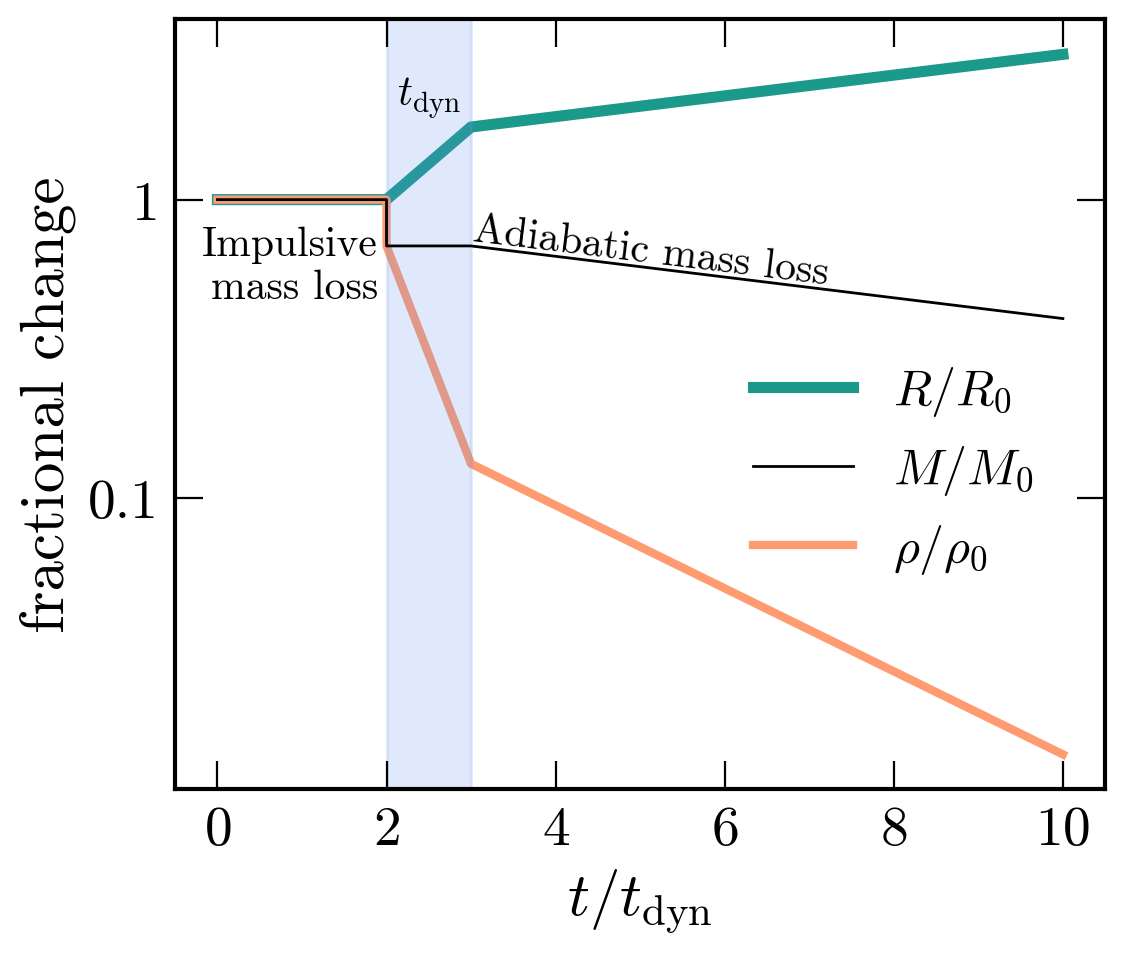

In [19]:
# analytic cluster expansion from Hills 1980

def R_R0_adiabatic(M0, delta_M):
    return M0/(M0-delta_M)

def R_R0_impulsive(M0, delta_M):
    # M_new = M0-delta_M
    return (M0-delta_M) / (M0 - 2*delta_M)


t_vals = np.array([0, 1, 1, 1.5, 5])

M_init = 1
R_init = 1
sigma_init = M_init/R_init

delta_M_impulsive = 0.3
R_final_impulsive = R_init * R_R0_impulsive(M_init, delta_M_impulsive)


delta_M_adiabatic = 0.3
R_final_adiabatic = R_final_impulsive * R_R0_adiabatic(M_init-delta_M_impulsive, delta_M_adiabatic)

print(R_init, R_final_impulsive, R_final_adiabatic)

R_vals = np.array([R_init, R_init, R_init, R_final_impulsive,  R_final_adiabatic])
M_vals = np.array([M_init, M_init, M_init-delta_M_impulsive,  M_init-delta_M_impulsive,
                   M_init-delta_M_impulsive-delta_M_adiabatic])

sigma_vals = M_vals / (R_vals)
rho_vals = M_vals / (R_vals**3)
t_dyn = 0.5

fig, ax = plt.subplots(figsize=[4*1.5,15/3], sharex=True)
plt.subplots_adjust(hspace=0.03, wspace=0.03)

ax.plot(t_vals/t_dyn, R_vals, label=r'$R/R_0$', c=lm_colors[2], zorder=0, lw=4)
ax.plot(t_vals/t_dyn, M_vals, label=r'$M/M_0$', c='k', linestyle="-", lw=1)
# ax.plot(t_vals/t_dyn, sigma_vals, label=r'$\sigma_v/\sigma_{v,0}$', c=hm_colors[2], zorder=0)
ax.plot(t_vals/t_dyn, rho_vals, label=r'$\rho/\rho_{0}$', c=hm_colors[2], zorder=0, lw=3)


ax.axvspan(1/t_dyn, 1.5/t_dyn, color='cornflowerblue', alpha=0.2)#, label=r'$t_{\rm dyn}$')
ax.text(1.25/t_dyn, 2.2, r"$t_{\rm dyn}$", ha='center', va='center', fontsize=15)

ax.legend(loc=[0.6,0.25])

ax.set_xlabel(r'$t/t_{\rm dyn}$')#, fontsize=15)
# ax.set_ylim(0,2.6)

ax.set_xticks([0,2,4,6,8,10])#, labels=[])
# ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
ax.set_yticks([0, 1, 2])


ax.set_yscale('log')

ax.text(1.9, 0.6, "Impulsive\nmass loss", va='center', ha='right', fontsize=15)#, transform=ax.transAxes)
ax.text(3., 0.67, "Adiabatic mass loss", rotation=-7, ha='left', va='center', fontsize=15)
ax.minorticks_off()
ax.set_yticks([0.1, 1], ['0.1','1'])
ax.set_ylabel("fractional change")
plt.savefig("plots/massloss_expansion_demonstration_density.pdf", dpi=300, bbox_inches='tight')

In [5]:
rho_vals

array([1.        , 1.        , 0.7       , 0.13061224, 0.13061224,
       0.02230703])

# poisson noise in N_ob

In [ ]:
m_kroupa = paf.gen_kroupa_IMF(N=int(4e7), m_max=150) # generate MANY draws from Kroupa 01 IMF for comparison to the IC draws.

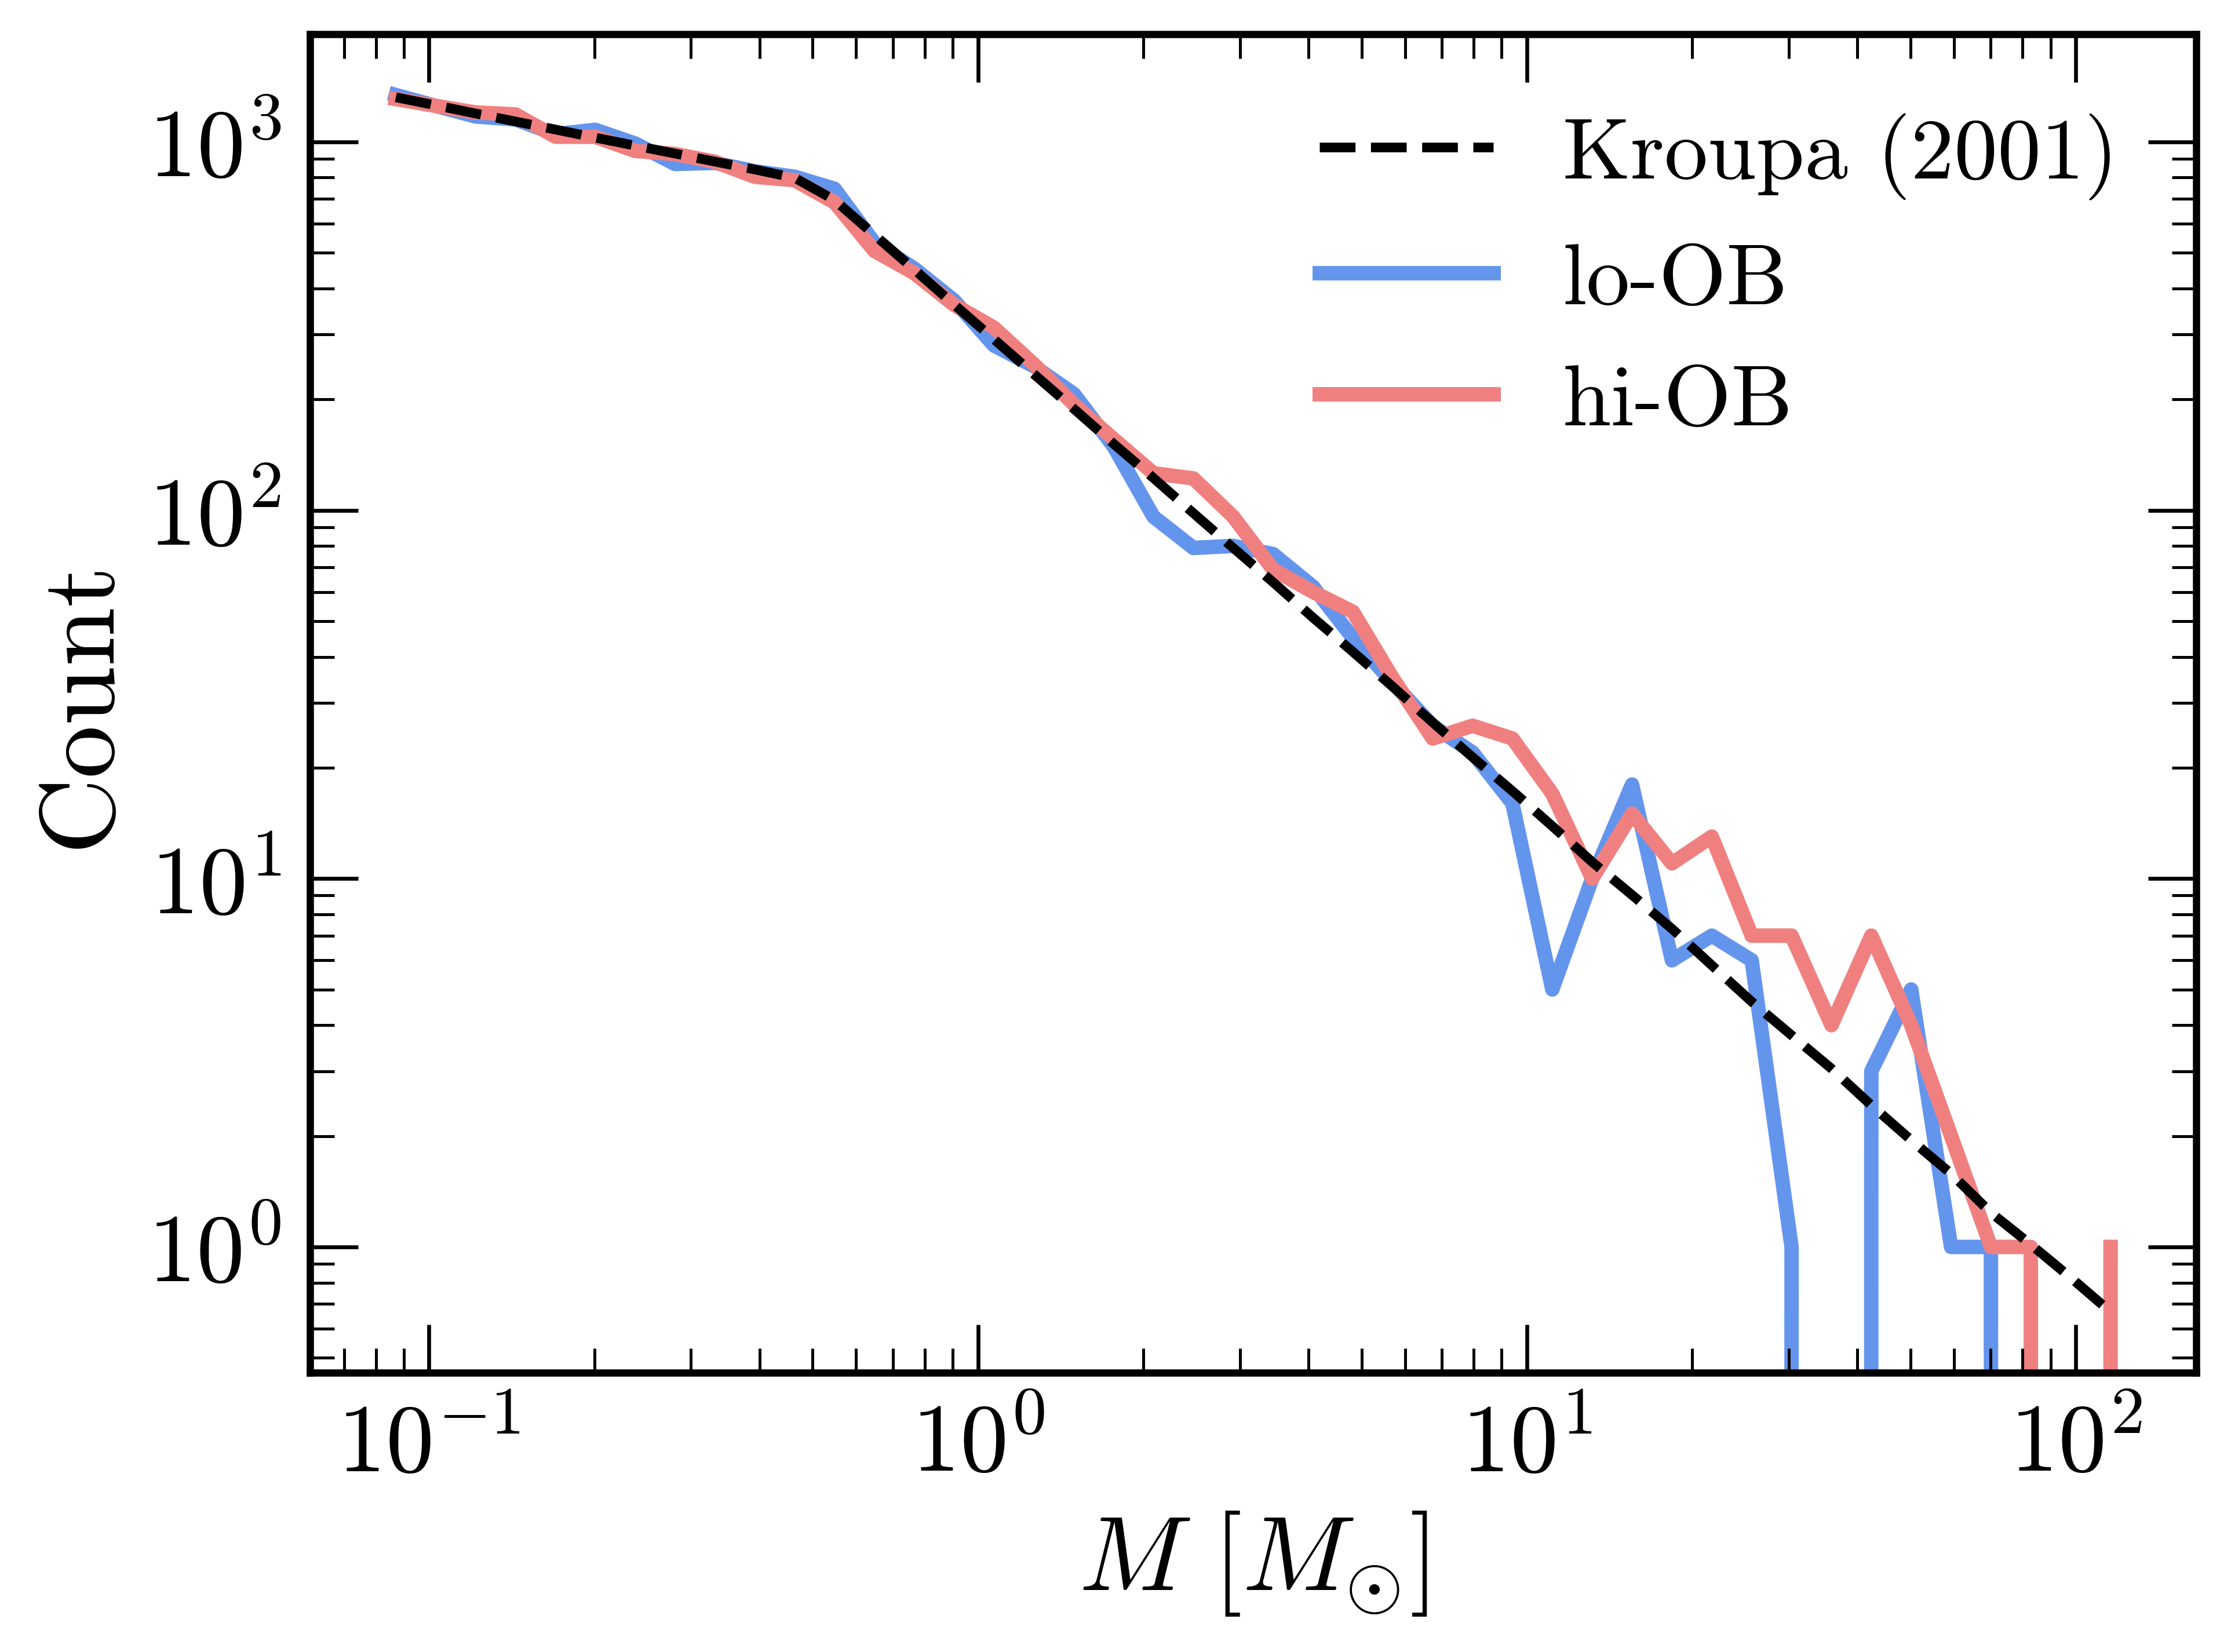

In [21]:
files = [paths[0]+"data.0", paths[1]+"data.0"]

fig, ax = plt.subplots(figsize=[7,5], dpi=300)
bins = np.linspace(np.log10(0.08), 2.1, 45)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_widths = np.diff(bins)

N=15000
y, _ = np.histogram(np.log10(m_kroupa), bins=bins)
ax.plot(10**bin_centers, y*(N/len(m_kroupa)), # NORMALIZE the large Kroupa draw.
        c='k', 
        linewidth=2, linestyle='--', label='Kroupa (2001)')#, zorder=0)

colors = ['cornflowerblue', 'lightcoral']
labels=["lo-OB", "hi-OB"]
for j, file in enumerate(files):
    particles=petar.Particle(interrupt_mode='bse', external_mode='galpy')
    particles.loadtxt(file, skiprows=1)

    m = particles.mass

    y, _ = np.histogram(np.log10(m), bins=bins)
    ax.plot(10**bin_centers, y, color=colors[j], label=labels[j], zorder=0)
    
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper right')
ax.set_xlabel(r'$M\ [M_{\odot}]$')
ax.set_ylabel(r"Count")

plt.savefig("plots/MF_stochasticity.pdf", dpi=300, bbox_inches='tight')